In [ ]:
# -----
# COLAB CELL 1
# -----

!pip install transformers
!pip install XGBoost
!pip install -U imbalanced-learn
!pip install imbalanced-learn

  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
Using cached imbalanced_learn-0.13.0-py3-none-any.whl (238 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 73.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.28.1 which is incompatible.


In [ ]:
# -----
# COLAB CELL 2
# -----

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report)
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Hugging Face Transformers
from transformers import DistilBertTokenizer, DistilBertModel

# XGBoost
from xgboost import XGBClassifier

# For saving model
import joblib

# Check GPU availability (for BERT embeddings)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [ ]:
# -----
# COLAB CELL 3
# -----

df = pd.read_csv("bot_detection_data.csv")  # adjust the path if necessary

print("Data shape:", df.shape)
df.head()


Data shape: (50000, 11)


,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags
0,132131,flong,Station activity person against natural majori...,85,1,2353,False,1,Adkinston,2020-05-11 15:29:50,NaN
1,289683,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,Sanderston,2022-11-26 05:18:10,both live
2,779715,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,Harrisonfurt,2022-08-08 03:16:54,phone ahead
3,696168,pmason,Just cover eight opportunity strong policy which.,54,5,2242,True,1,Martinezberg,2021-08-14 22:27:05,ever quickly new I
4,704441,noah87,Animal sign six data good or.,26,3,8438,False,1,Camachoville,2020-04-13 21:24:21,foreign mention


In [ ]:
# -----
# COLAB CELL 4
# -----

# Fill missing 'Hashtags' with an empty string
df['Hashtags'] = df['Hashtags'].fillna("")

# Confirm the fill
print("Number of missing values in 'Hashtags':", df['Hashtags'].isna().sum())


Number of missing values in 'Hashtags': 0


In [ ]:
# -----
# COLAB CELL 5
# -----

# If Verified is bool, convert to int
# (Not strictly necessary if the model can handle bool, but some models prefer numeric)
if df['Verified'].dtype == bool:
    df['Verified'] = df['Verified'].astype(int)


In [ ]:
# -----
# COLAB CELL 6
# -----

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove punctuation (keep spaces)
    text = re.sub(r'[^\w\s]', '', text)
    # Strip extra whitespace
    text = text.strip()
    return text

df['Cleaned_Tweet'] = df['Tweet'].astype(str).apply(clean_text)
df[['Tweet','Cleaned_Tweet']].head()


,Tweet,Cleaned_Tweet
0,Station activity person against natural majori...,station activity person against natural majori...
1,Authority research natural life material staff...,authority research natural life material staff...
2,Manage whose quickly especially foot none to g...,manage whose quickly especially foot none to g...
3,Just cover eight opportunity strong policy which.,just cover eight opportunity strong policy which
4,Animal sign six data good or.,animal sign six data good or


In [ ]:
# -----
# COLAB CELL 7
# -----

df['Tweet_Length'] = df['Cleaned_Tweet'].apply(len)

# Count the number of hashtags in the Hashtags column (assuming comma-separated or space-separated)
df['Hashtag_Count'] = df['Hashtags'].apply(lambda x: len(x.split()) if x != "" else 0)

# FollowerPerRetweet (avoid division by zero by adding +1 to Retweet Count)
df['FollowerPerRetweet'] = df['Follower Count'] / (df['Retweet Count'] + 1)

df[['Tweet_Length', 'Hashtag_Count', 'FollowerPerRetweet']].describe()


,Tweet_Length,Hashtag_Count,FollowerPerRetweet
count,50000.000000,50000.000000,50000.000000
mean,61.627340,2.500260,259.609842
std,16.471543,1.709368,702.372704
min,22.000000,0.000000,0.000000
25%,48.000000,1.000000,48.845459
50%,61.000000,2.000000,97.968246
75%,75.000000,4.000000,194.158242
max,117.000000,5.000000,9933.000000


In [ ]:
# -----
# COLAB CELL 8
# -----

# Ensure the Bot Label is either 0 or 1
# If the current data is 0/1, this step is not changing anything.
# If there's a case it is 1/2 or True/False, adapt as necessary.
df['Bot Label'] = df['Bot Label'].apply(lambda x: 1 if x == 1 else 0)

print(df['Bot Label'].value_counts())


Bot Label
1    25018
0    24982
Name: count, dtype: int64


In [ ]:
# -----
# COLAB CELL 9
# -----

# Define numeric features
numeric_features = [
    'Retweet Count',
    'Mention Count',
    'Follower Count',
    'Verified',
    'Tweet_Length',
    'Hashtag_Count',
    'FollowerPerRetweet'
]

# Our input feature sets
X_text = df['Cleaned_Tweet'].values
X_numeric = df[numeric_features].values

y = df['Bot Label'].values  # target

# Train-Test Split
X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_text, X_numeric, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_text_train.shape[0], "Test size:", X_text_test.shape[0])


Train size: 40000 Test size: 10000


In [ ]:
# -----
# COLAB CELL 10
# -----

# Initialize the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
bert_model.to(device)
bert_model.eval()

def get_bert_embeddings(text_list, batch_size=32):
    """
    text_list: list or array of strings (cleaned tweets).
    batch_size: you can adjust based on GPU memory.

    Returns a numpy array of shape (len(text_list), hidden_size).
    DistilBERT's hidden_size is typically 768.
    """
    embeddings = []
    # Process in batches for efficiency
    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i : i + batch_size].tolist()

        # Tokenize
        encodings = tokenizer(batch_texts, truncation=True, padding=True, return_tensors='pt', max_length=64)
        # Move to GPU if available
        input_ids = encodings['input_ids'].to(device)
        attention_mask = encodings['attention_mask'].to(device)

        with torch.no_grad():
            # DistilBERT outputs: last_hidden_state
            outputs = bert_model(input_ids, attention_mask=attention_mask)
            # We can take the [CLS] token (first token) representation
            # DistilBERT doesn't have a separate CLS token embedding in the same way,
            # but we can simply take the first token of the last hidden state.
            last_hidden_state = outputs.last_hidden_state
            # Average Pooling or use the first token
            # Let's do mean pooling across tokens for a more robust embedding
            mean_embeddings = last_hidden_state.mean(dim=1)  # shape: (batch_size, 768)

        # Convert to CPU numpy
        mean_embeddings = mean_embeddings.cpu().numpy()
        embeddings.append(mean_embeddings)

    # Concatenate all
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

# Let's embed the train and test text
print("Embedding train data ...")
X_bert_train = get_bert_embeddings(X_text_train)

print("Embedding test data ...")
X_bert_test = get_bert_embeddings(X_text_test)

print("X_bert_train shape:", X_bert_train.shape)
print("X_bert_test  shape:", X_bert_test.shape)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding train data ...
Embedding test data ...
X_bert_train shape: (40000, 768)
X_bert_test  shape: (10000, 768)


In [ ]:
# -----
# COLAB CELL 11
# -----

scaler = StandardScaler()
X_num_train_scaled = scaler.fit_transform(X_num_train)
X_num_test_scaled = scaler.transform(X_num_test)

# Combine [BERT embeddings] + [scaled numeric features]
X_train_combined = np.concatenate((X_bert_train, X_num_train_scaled), axis=1)
X_test_combined = np.concatenate((X_bert_test, X_num_test_scaled), axis=1)

print("X_train_combined shape:", X_train_combined.shape)
print("X_test_combined shape:", X_test_combined.shape)


X_train_combined shape: (40000, 775)
X_test_combined shape: (10000, 775)


In [ ]:
# -----
# COLAB CELL 12
# -----

# Check class distribution
unique, counts = np.unique(y_train, return_counts=True)
print("Class distribution in train set:", dict(zip(unique, counts)))

apply_smote = False  # Set to True if you want to apply SMOTE

if apply_smote:
    sm = SMOTE(random_state=42)
    X_train_combined, y_train = sm.fit_resample(X_train_combined, y_train)
    print("After SMOTE, X_train shape:", X_train_combined.shape, "y_train shape:", y_train.shape)
    unique, counts = np.unique(y_train, return_counts=True)
    print("Class distribution after SMOTE:", dict(zip(unique, counts)))


Class distribution in train set: {0: 19986, 1: 20014}


In [ ]:
# -----
# COLAB CELL 13
# -----

# Initialize the model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Train the model
xgb_model.fit(X_train_combined, y_train)

# Predictions
y_train_pred = xgb_model.predict(X_train_combined)
y_test_pred = xgb_model.predict(X_test_combined)

# Probabilities (for AUC/ROC)
y_train_proba = xgb_model.predict_proba(X_train_combined)[:, 1]
y_test_proba = xgb_model.predict_proba(X_test_combined)[:, 1]


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [ ]:
# -----
# COLAB CELL 14
# -----

def evaluate_model(y_true, y_pred, y_proba, dataset_label="Train"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)

    print(f"=== {dataset_label} Metrics ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"AUC-ROC:   {auc:.4f}")
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print("====================================\n")

# Evaluate on train
evaluate_model(y_train, y_train_pred, y_train_proba, "Train")

# Evaluate on test
evaluate_model(y_test, y_test_pred, y_test_proba, "Test")


=== Train Metrics ===
Accuracy:  0.8422
Precision: 0.8420
Recall:    0.8427
F1-score:  0.8423
AUC-ROC:   0.9280

Confusion Matrix:
[[16822  3164]
 [ 3149 16865]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     19986
           1       0.84      0.84      0.84     20014

    accuracy                           0.84     40000
   macro avg       0.84      0.84      0.84     40000
weighted avg       0.84      0.84      0.84     40000


=== Test Metrics ===
Accuracy:  0.5029
Precision: 0.5033
Recall:    0.5074
F1-score:  0.5053
AUC-ROC:   0.5017

Confusion Matrix:
[[2490 2506]
 [2465 2539]]

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      4996
           1       0.50      0.51      0.51      5004

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50

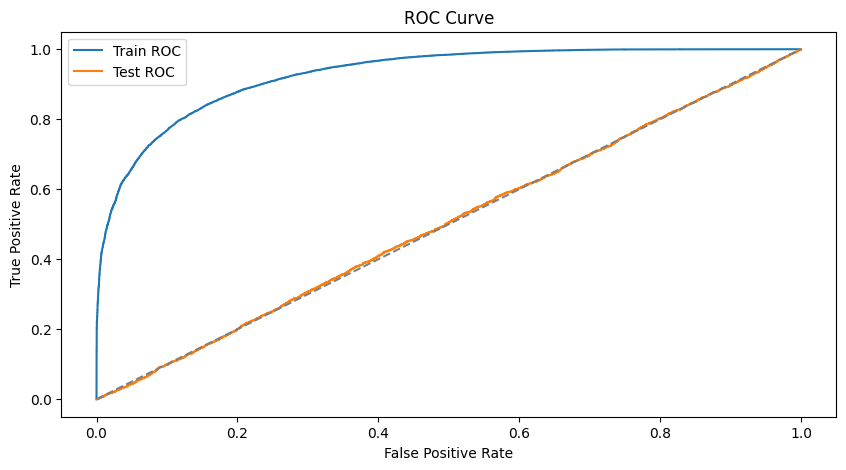

In [ ]:
# -----
# COLAB CELL 15
# -----

from sklearn.metrics import roc_curve

plt.figure(figsize=(10,5))

# Train ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
plt.plot(fpr_train, tpr_train, label='Train ROC')

# Test ROC
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr_test, tpr_test, label='Test ROC')

plt.plot([0,1],[0,1], color='gray', linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [ ]:
# -----
# COLAB CELL 16
# -----

# Save XGBoost model
joblib.dump(xgb_model, "xgb_bot_detection_model.pkl")
# Save Scaler
joblib.dump(scaler, "scaler.pkl")

print("Models saved successfully!")


Models saved successfully!
